# 透過 Airbnb Inside data分析 Toronto 房產是否具投資價值
資料來源:http://insideairbnb.com/get-the-data.html  

In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
%matplotlib inline 
import plotly.offline as py 
py.init_notebook_mode(connected=True) # 為了能在本地端調用
import plotly.graph_objs as go
import plotly.tools as tls
import chart_studio.plotly as py               #plotly.plotly module is deprecated
import plotly.figure_factory as ff  #會噴error
#from plotly.tools import FigureFactory as ff
import cufflinks as cf  #這個mode
import seaborn as sns
plt.rcParams['font.sans-serif'] = ['KaiTi']

import cufflinks error

https://community.plotly.com/t/cufflinks-error-importerror-cannot-import-name-figurewidget/25610    

Python一行代碼搞定炫酷可視化，Cufflinks值得擁有

https://kknews.cc/code/gm9mjrm.html

In [2]:
calendar = pd.read_csv('C:/Users/user/Desktop/medium文案/Finformation當資料科學遇上財務金融/toranto house data/calendar.csv')
print('資料總共有',calendar.date.nunique() , '天及' , calendar.listing_id.nunique() ,'不同的清單在我們的calendar中')
print(calendar.date.min() , calendar.date.max())
print('資料共',calendar.shape[0],'列','及',calendar.shape[1],'欄')
calendar.tail()
#calendar.info()


資料總共有 369 天及 18265 不同的清單在我們的calendar中
2021-01-02 2022-01-05
資料共 6667637 列 及 7 欄


,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights
6667632,47076188,2021-12-29,f,$280.00,$252.00,1.0,1125.0
6667633,47076188,2021-12-30,f,$280.00,$252.00,1.0,1125.0
6667634,47076188,2021-12-31,f,$280.00,$252.00,1.0,1125.0
6667635,47076188,2022-01-01,f,$280.00,$252.00,1.0,1125.0
6667636,47076188,2022-01-02,f,$280.00,$252.00,1.0,1125.0


資料描述:   
listing_id  
date   
available   
available t/f 為是否可以入住  t為可以訂房/f則為已被預訂  
price   
adjusted_price   
minimum_nights  
maximum_nights  

Text(0.5, 1.0, 'Available ratio')

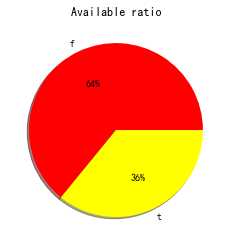

In [3]:
color = ["red", "yellow"]
labels = set([i for i in calendar['available'].values])
plt.pie(calendar.available.value_counts(), labels = labels, colors = color,autopct='%.0f%%',shadow=True,radius=1) # 繪製圓餅圖
#這邊看出空房率還是很高的
plt.title("Available ratio")

Text(0, 0.5, '%Busy')

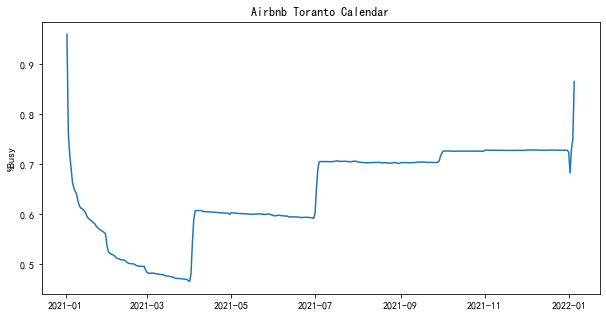

In [4]:
#想了解一年中哪些時刻淡旺季,利用時間序列與 t/f看出哪段時間空房多,就是淡季(即t較高)
#code前要先定義淡旺季的意思,數學上如何表示,再code出來
#其實旅遊業的淡旺季是有特定指標稱為「滿房率」
#因此在進行數據分析前,除了運用數學統計邏輯思考以外,可以針對資料領域的Domain knowhow進行了解再code,這樣站在巨人肩膀上
#分析的專業度上會更加提升,且更能貼合,該領域習慣,原有的分析狀態,之後才會進而做改良,不論是指標上或是BI上

new_calendar = calendar[['date' , 'available']]
new_calendar['busy'] = new_calendar.available.map(lambda x:0 if x == 't' else 1)

new_calendar = new_calendar.groupby('date')['busy'].mean().reset_index() #id每間房間在368天的 t/f加總平均為多少 0<X<1
new_calendar['date'] = pd.to_datetime(new_calendar['date'])#轉換Dtype,畫x軸時會顯示日期(plt)

plt.figure(figsize = (10 , 5))
plt.plot(new_calendar['date'] , new_calendar['busy'])
plt.title('Airbnb Toranto Calendar')
plt.ylabel('%Busy')

# 「滿房率」定義及公式

Text(0, 0.5, 'Month')

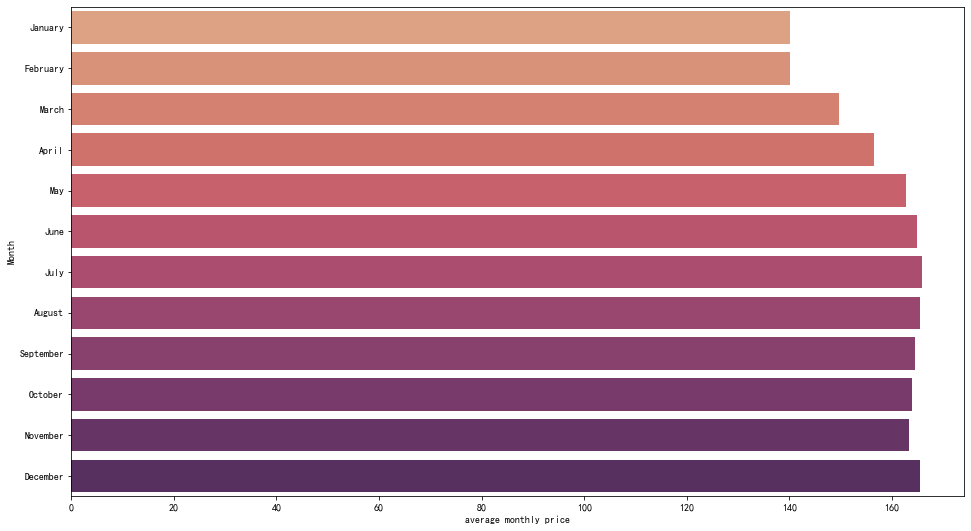

In [5]:
#再來思考商業模式中的售價,售價會影響營收,因此切入分析
#思考這筆投資在哪一月份中的 P 最高,再思考是否可以應用 Peak-load pricing 執行價格管控獲取最大利潤
#除了管理學上的理論外,culture也是很重要的,BI中數據異常時透過對local culture的了解會有助於找出原因,進而催生出解決方案
calendar['date'] = pd.to_datetime(calendar['date'])

calendar['price'] = calendar['price'].str.replace(',','').str.replace('$' , '').astype(float) #處理數據 #這裡無法重複執行,再次執行要註解掉

mean_of_month = calendar.groupby(calendar['date'].dt.strftime('%B') , sort = False)['price'].mean() #dt進階操作

#其實這個平均價格可以考慮要不要分類,listing_id為不同的物件,價格有高有低,等級也會有所不同,可以考慮以價格區分出等級再計算每個區間的價格平均
#就可以得到更細節的數據,至於價格區間如何訂定?,可以參考airbnb官網消費者選取價格的區間作為依據


#mean_of_month.plot(kind = 'barh' , figsize = (12,7))
plt.figure(figsize=(16,9)) #要先設定在數據前面
sns.barplot(y=mean_of_month.index,x=mean_of_month.values,palette="flare")
plt.xlabel('average monthly price')
plt.ylabel('Month')

Python3 pandas库(25) 时间日期高效操作   
https://zhuanlan.zhihu.com/p/31490318

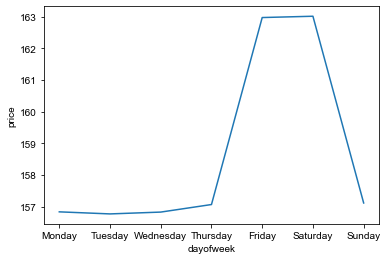

In [6]:
#1,2月份普遍比較少人來價格較低,可以深入了解為甚麼,從質量分析去找原因,及量化分析找佐證
#那我們再進一步了解週間熱門程度
import datetime
calendar['dayofweek'] = calendar.date.dt.weekday
dayofweek = []
week_days = ["Monday","Tuesday","Wednesday","Thursday","Friday","Saturday","Sunday"]

for i  in calendar['dayofweek']:
    a = week_days[i]
    dayofweek.append(a)
 
calendar['dayofweek'] = dayofweek

price_week = calendar.groupby('dayofweek')['price'].mean().reindex(week_days)
sns.lineplot(data=price_week,)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette('bright'))

plotly   
https://plotly.com/python/ipython-notebook-tutorial/

In [7]:
#上面的價格在週五~週六突然拉高,會不會是因為跨年,數據 head,tail拉出來看,確實2022年跨年是在週五~週六,進一步思考可以如何利用columns分析

calendar.tail()
calendar.head()
s = calendar 
跨年 = s[s.date == '2021-12-31' ]['price'].mean() #指在12/31號當天的平均租房價
整年 = s['price'].mean() #整年度平均租房價
print(跨年,整年)


171.38018067341912 158.65259431489747


In [8]:
listing = pd.read_csv('C:/Users/user/Desktop/medium文案/Finformation當資料科學遇上財務金融/toranto house data/listings.csv')
listingsdeep = pd.read_csv('C:/Users/user/Desktop/medium文案/Finformation當資料科學遇上財務金融/toranto house data/listingsdeep.csv')
print('我們有' , listing.id.nunique() , '筆資料')
#listing.info()
listing.head(3)
listingsdeep.head()

我們有 18265 筆資料


,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1419,https://www.airbnb.com/rooms/1419,20210102020445,2021-01-02,Beautiful home in amazing area!,"This large, family home is located in one of T...",The apartment is located in the Ossington stri...,https://a0.muscache.com/pictures/76206750/d643...,1565,https://www.airbnb.com/users/show/1565,...,10.0,10.0,10.0,NaN,f,1,1,0,0,0.11
1,8077,https://www.airbnb.com/rooms/8077,20210102020445,2021-01-04,Downtown Harbourfront Private Room,Guest room in a luxury condo with access to al...,NaN,https://a0.muscache.com/pictures/11780344/141c...,22795,https://www.airbnb.com/users/show/22795,...,10.0,10.0,10.0,NaN,t,2,1,1,0,1.22
2,12604,https://www.airbnb.com/rooms/12604,20210102020445,2021-01-02,Seaton Village Parlour Bedroom,Comfortable sofa bed in airy main floor parlou...,NaN,https://a0.muscache.com/pictures/5282025/91fca...,48239,https://www.airbnb.com/users/show/48239,...,NaN,NaN,NaN,NaN,f,1,0,1,0,NaN
3,23691,https://www.airbnb.com/rooms/23691,20210102020445,2021-01-03,Queen Bedroom close to downtown,<b>The space</b><br />Nestled in the middle of...,NaN,https://a0.muscache.com/pictures/615528/d09ab3...,93825,https://www.airbnb.com/users/show/93825,...,10.0,9.0,10.0,NaN,t,2,0,2,0,1.68
4,27423,https://www.airbnb.com/rooms/27423,20210102020445,2021-01-05,Executive Studio Unit- Ideal for One Person,"Brand new, fully furnished studio basement apa...",NaN,https://a0.muscache.com/pictures/176936/b687ed...,118124,https://www.airbnb.com/users/show/118124,...,10.0,10.0,10.0,NaN,f,1,1,0,0,0.20


In [9]:
listing.shape
listingsdeep.shape

(18265, 74)

In [10]:
listing.columns
listingsdeep.columns
#listingsdeep.neighbourhood_cleansed

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_id', 'host_url',
       'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_upd

Understandig Data - Airbnb listing popularity analysis based on Barcelona data   
https://rstudio-pubs-static.s3.amazonaws.com/407929_afc5ef0f2ad648389447a6ca3f4a7cd4.html     
Airbnb in Seattle — Data Analysis   
https://jinglescode.github.io/2019/07/13/airbnb-in-seattle-data-analysis/    
AirBnB Analysis   
https://www.kaggle.com/aashirwad01/airbnb-analysis

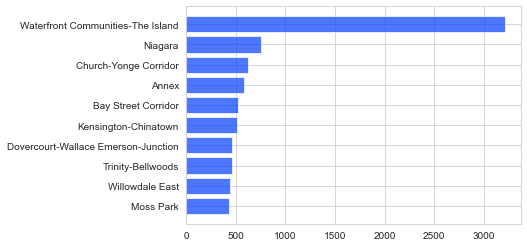

In [11]:
grouped_df = listingsdeep.groupby('neighbourhood_cleansed').count()[['id']].sort_values('id' , ascending = True).tail(10)#哪一個區域中的房源比較多

ticks = np.arange(len(grouped_df.id))
plt.barh(grouped_df.index,grouped_df.id,alpha=0.7,)
plt.show()
#Waterfront Communities-The Island 擁有房源供給非常多,可以深入研究why?

[Python 商業數據分析之可視化繪圖] 第6講：條形圖(Bar Chart)   
https://medium.com/python-%E8%B3%87%E6%96%99%E8%A6%96%E8%A6%BA%E5%8C%96/python-%E5%95%86%E6%A5%AD%E6%95%B8%E6%93%9A%E5%88%86%E6%9E%90%E4%B9%8B%E5%8F%AF%E8%A6%96%E5%8C%96%E7%B9%AA%E5%9C%96-%E7%AC%AC6%E8%AC%9B-%E6%A2%9D%E5%BD%A2%E5%9C%96-bar-chart-cdb137fb4db0  

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 35413 missing from current font.

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 20729 missing from current font.

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 20998 missing from current font.

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\ba

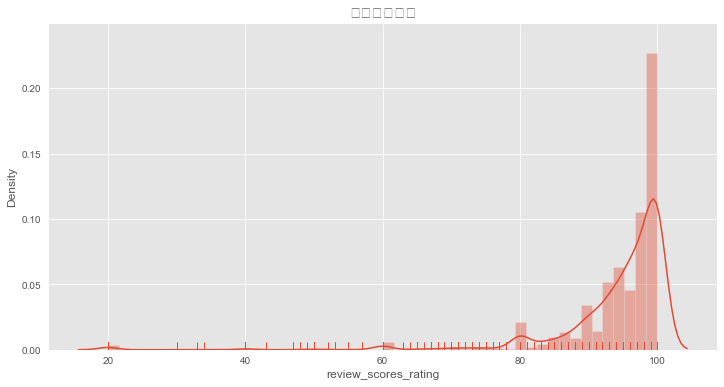

In [12]:
plt.style.use('ggplot')
plt.figure(figsize = (12 , 6))
plt.title('評價分數分析' , fontsize = 15)
sns.distplot(listingsdeep.review_scores_rating.dropna() , rug = True,)
sns.despine()

count    18265.000000
mean       137.659667
std        306.423240
min          0.000000
25%         60.000000
50%         95.000000
75%        149.000000
max      13000.000000
Name: price, dtype: float64


C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2056: FutureWarning:

The `axis` variable is no longer used and will be removed. Instead, assign variables directly to `x` or `y`.

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 20840 missing from current font.

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 37096 missing from current font.

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning:

Glyph 25151 missing from current font.

C:\Users\user\anaconda3\lib\site-packages\matplotlib\backends\ba

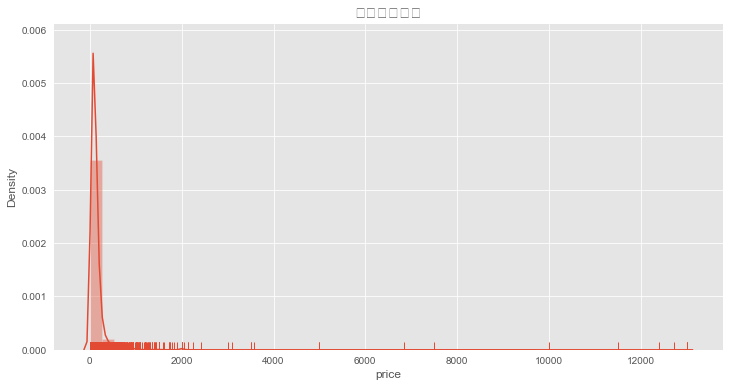

In [13]:
#當地房價分布
listingsdeep['price'] = listingsdeep['price'].str.replace(',' , '').str.replace('$' , '').astype(float)

print(listingsdeep.price.describe())
plt.figure(figsize = (12 , 6))
plt.title('全部房價分佈' , fontsize = 15)
sns.distplot(listingsdeep.price.dropna() , rug = True)
sns.despine()

In [14]:
# [i for i in listingsdeep.price if i >2000]
# listingsdeep[listingsdeep.price > 2000]   #.description.iloc[0] #大於2000元的房子,
# #我們可以透過description 觀察這些房子附近的生活機能,藉此了解什麼樣的房子開價這麼高~~
# #listingsdeep[listingsdeep.price >2000].sort_values('price' , ascending = False)
# listingsdeep[listingsdeep.price > 8000] #8000以上可能太貴,想排除觀察一下數據

# plt.figure(figsize = (12 , 6))
# plt.title('房價大致的分佈' , fontsize = 15)
# sns.distplot(listingsdeep[listingsdeep.price < 8000].price.dropna() , rug = True)
# sns.despine()

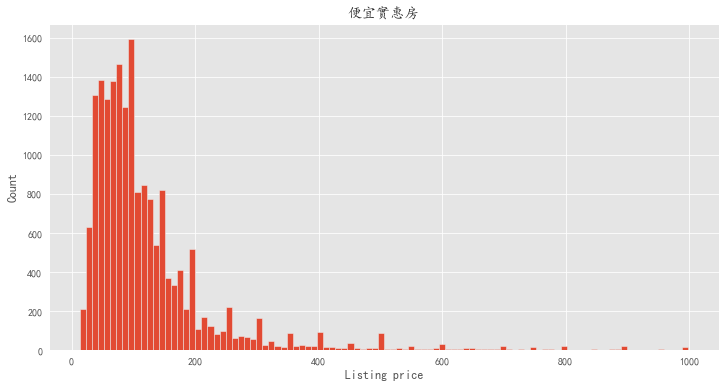

In [15]:
plt.figure(figsize = (12,6))
listingsdeep.loc[(listingsdeep.price < 1000) & (listingsdeep.price > 0)].price.hist(bins  = 100)
plt.ylabel('Count')
plt.xlabel('Listing price')
plt.title('便宜實惠房')
plt.rcParams['font.sans-serif'] = ['KaiTi']

In [16]:
dic = {}

for i in [i for i in grouped_df.index]:
    dic.setdefault(i,[i for i in listingsdeep.loc[listingsdeep.neighbourhood_cleansed.str.contains(i)]['price']])


In [17]:
all_price = []
for i in [i for i in grouped_df.index]:
      a = list(dic[i])
      all_price.append(a)  
print(len(all_price[1]))

448


<AxesSubplot:title={'center':'各個區域的房價分佈'}, xlabel='neighbourhood_cleansed', ylabel='price'>

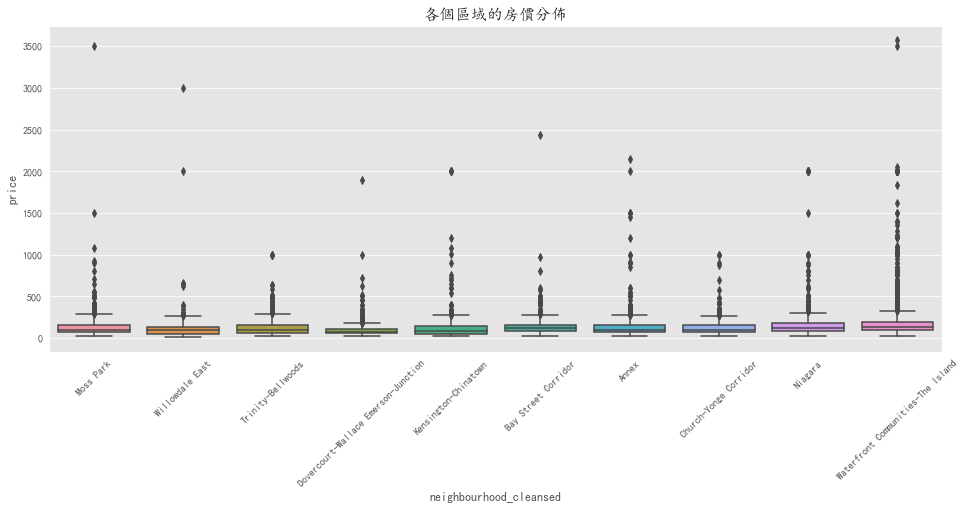

In [18]:
#由於加拿大區域太多,房源供給前10名,各個區域的房價分佈
drop_outlier_price_condition = listingsdeep.loc[(listingsdeep.price<=4000) & (listingsdeep.price > 0)]

plt.figure(figsize = (16 , 6))   
plt.title('各個區域的房價分佈' , fontsize = 16)
plt.xticks(rotation = 45)
sns.boxplot(y='price' , x = 'neighbourhood_cleansed' , data = drop_outlier_price_condition , order=  grouped_df.index,)
#data有篩選出來,order打出相對應的名稱就會跑出盒狀圖,非常方便
#有些地方outlier很多,雖然可能是Waterfront Communities-The Island房源真的太多,高出第二位畢竟快 7倍 

<AxesSubplot:title={'center':'room_type 屬性的影響'}, xlabel='room_type', ylabel='price'>

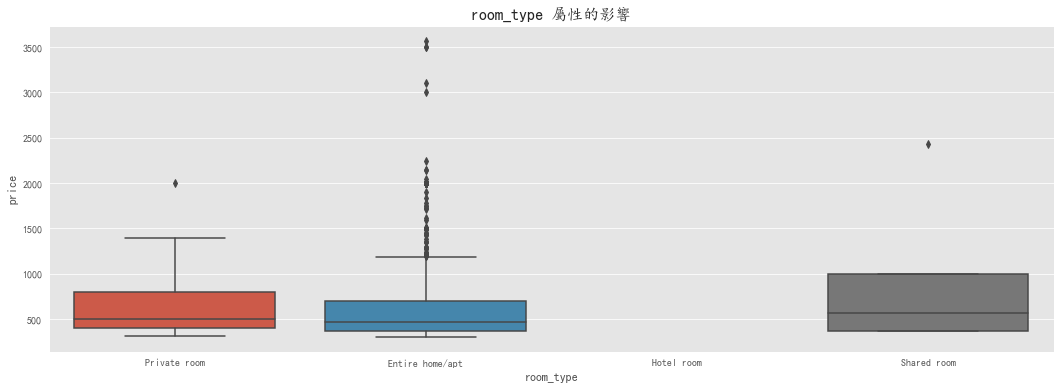

In [19]:
drop_outlier_price_condition = listingsdeep.loc[(listingsdeep.price<=4000) & (listingsdeep.price > 300)]


    
plt.figure(figsize = (18,6))
plt.title( 'room_type 屬性的影響' , fontsize = 16)
sns.boxplot(y=  'price' , x=  'room_type' , data = drop_outlier_price_condition , order = set(listing.room_type))
#發現 Hotel room 的盒狀分析圖不見了?觀察一下資料,因為y軸是價格,可能是價格上有些貓逆

In [20]:
[i for i in listingsdeep.room_type ].count('Hotel room')
listingsdeep.loc[listingsdeep.room_type.str.contains('Hotel room')]['price']
#結果發現原來 room_type中的 Hotel room 房價偏低,因此把下限調整一下

529      102.0
531      261.0
939       35.0
5027      72.0
5030      36.0
5031      36.0
5032      36.0
5033      36.0
6089      36.0
6106      36.0
6119      72.0
6165      36.0
6623      36.0
6728      32.0
6739      32.0
6770      32.0
7248     199.0
8114     133.0
8146     181.0
8147     172.0
8422     149.0
8423     159.0
8424     149.0
8425     179.0
8580     181.0
8582     181.0
8585     133.0
8587     133.0
8590     151.0
8591     151.0
8592     151.0
8595     151.0
8597     151.0
10264     35.0
11595     78.0
11731     79.0
11806     75.0
11818     75.0
11821     75.0
11822     75.0
11823     75.0
11824     75.0
11825     75.0
11827     75.0
11832     75.0
12746     38.0
12801     99.0
12824     57.0
12933    112.0
12935     76.0
12936     77.0
12937     67.0
13155     80.0
13388     99.0
13390     35.0
13395     35.0
15413      0.0
15793      0.0
Name: price, dtype: float64

<AxesSubplot:title={'center':'room_type 屬性的影響'}, xlabel='room_type', ylabel='price'>

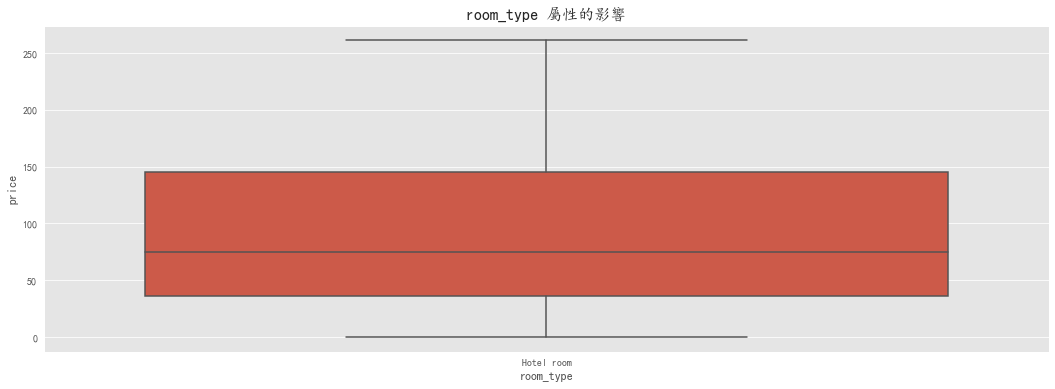

In [21]:
Hotel_room_price= listingsdeep.loc[listingsdeep.room_type.str.contains('Hotel room')]
#因為它價格太低了,單獨做一盒子好了
order = ['Hotel room']
    
plt.figure(figsize = (18,6))
plt.title( 'room_type 屬性的影響' , fontsize = 16)
sns.boxplot(y=  'price' , x=  'room_type' , data = Hotel_room_price , order = order)

In [23]:

dic = {}
for i in  set(listingsdeep.property_type):
    property_count = list((listingsdeep.property_type)).count(i)
    dic.setdefault(i,property_count)

dic

{'Private room in casa particular': 2,
 'Room in serviced apartment': 4,
 'Private room in castle': 1,
 'Shared room in condominium': 53,
 'Private room in train': 1,
 'Shared room in townhouse': 32,
 'Private room in farm stay': 1,
 'Private room in serviced apartment': 11,
 'Barn': 1,
 'Entire villa': 13,
 'Shared room in bed and breakfast': 2,
 'Entire townhouse': 319,
 'Private room in boat': 1,
 'Entire condominium': 4179,
 'Entire floor': 5,
 'Shared room in guesthouse': 2,
 'Room in bed and breakfast': 4,
 'Camper/RV': 2,
 'Entire bungalow': 211,
 'Shared room in apartment': 99,
 'Private room in loft': 32,
 'Private room in guest suite': 146,
 'Entire loft': 314,
 'Shared room in barn': 2,
 'Private room in cottage': 5,
 'Entire guest suite': 690,
 'Entire place': 9,
 'Private room in hostel': 4,
 'Entire house': 1869,
 'Private room in house': 2861,
 'Shared room in villa': 2,
 'Shared room': 1,
 'Private room in barn': 3,
 'Private room in cave': 3,
 'Boat': 4,
 'Private room

In [24]:
# for i in  set(listingsdeep.property_type):
#     if dic[i] < 20:
#         del dic[i]
dic  
dic_fix = pd.Series(dic,index=dic.keys())
dic_fix

Private room in casa particular         2
Room in serviced apartment              4
Private room in castle                  1
Shared room in condominium             53
Private room in train                   1
                                     ... 
Entire apartment                     3823
Private room in bed and breakfast      34
Room in boutique hotel                 87
Private room in tiny house              9
Private room in floor                   3
Length: 67, dtype: int64

In [25]:
drop_outlier_price_condition.pivot(columns = 'property_type' , values ='price').iplot(kind = 'box')
grouped_df = drop_outlier_price_condition.pivot(columns = 'room_type' , values ='price')
grouped_df.iplot(kind = 'hist' , title = 'Entire home/apt 價格從貴到便宜都有')

<AxesSubplot:>

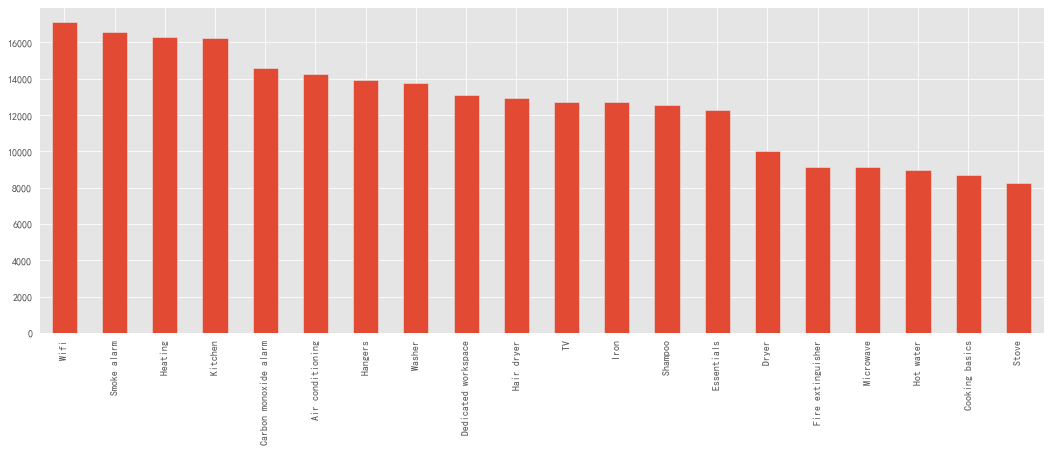

In [26]:
#如果房東要提高租屋品質該注意時麼
listingsdeep['amenities'] = listingsdeep.amenities.str.replace('[{}]' , '').str.replace('"','')
listingsdeep.amenities.head()
all_item_ls = np.concatenate(listingsdeep.amenities.map(lambda am:am.split(',')))
Top20_item = pd.Series(all_item_ls).value_counts().head(20)
plt.figure(figsize=  (18 , 6))
Top20_item.plot(kind = 'bar')
#plt.xticks(rotation = 45)
#wifi好像是全世界都很重要的事情,再來是吸菸區,跟廚房烤箱諸如跟「吃」有關的事

<Figure size 1296x432 with 0 Axes>

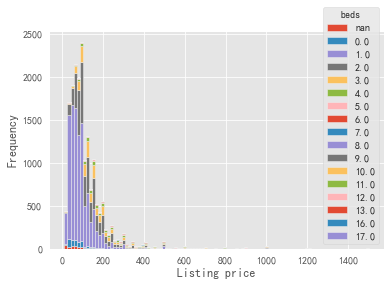

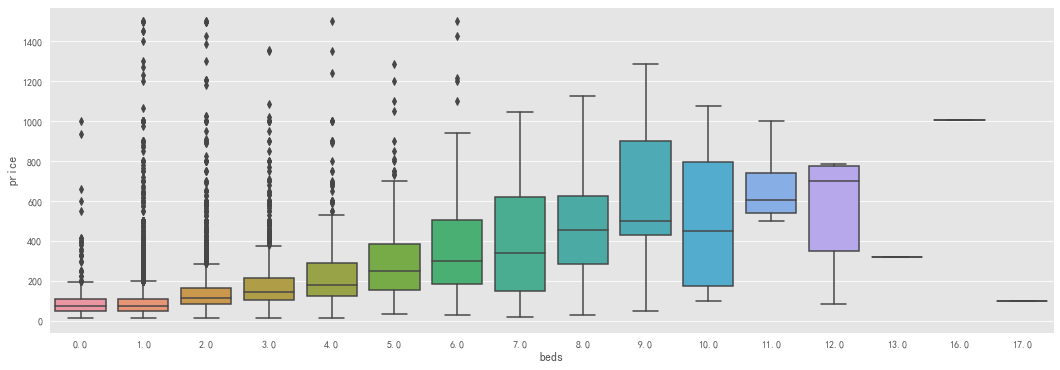

In [27]:
plt.figure(figsize = (18 , 6))
drop_outlier_price_condition = listingsdeep.loc[(listingsdeep.price<=1500) & (listingsdeep.price > 0)]
drop_outlier_price_condition.pivot(columns='beds' , values = 'price')\
.plot( kind = 'hist', stacked = True, bins =100)
plt.xlabel('Listing price')
plt.figure(figsize = (18,6))
sns.boxplot(y=  'price' , x=  'beds' , data = drop_outlier_price_condition)
plt.show()
#感覺單人床佔大部分
#然後單人床也是從高級到便宜都有
#然後10張床以上感覺像青旅?大家一起睡?

check  list:   
1.房價分析尋找會影響房價的變量   
2.category label 處理讓sklearn看的懂    
3.lost value    
4.test data,train data,   
5.cross validation  Baseline（基礎比較）L1、L2 Regression   
6.Random Forest、XGboost Regressor (modeling)   
7.利用model畫出變數重要性，方便我們優化模型    
8.持續優化    

<AxesSubplot:>

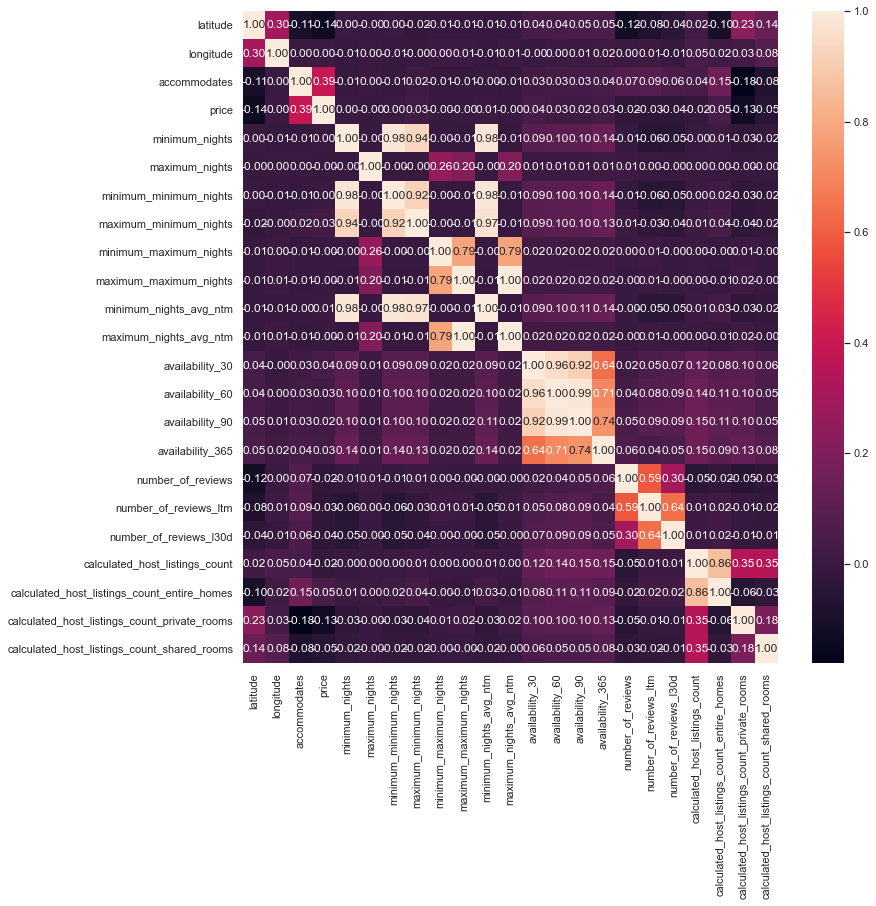

In [28]:
continual_var = listingsdeep.select_dtypes(np.number).columns  #選取數字型資料
drop_outlier_price_condition = listingsdeep.loc[(listingsdeep.price<=4000) & (listingsdeep.price > 0)]
no_null_col = drop_outlier_price_condition[continual_var].isnull().sum()==0
no_null_col = no_null_col[no_null_col == True].index.tolist()

#移除掉id類別的變量
no_null_col = no_null_col[3:]

corr = drop_outlier_price_condition[no_null_col].dropna().corr()
plt.figure(figsize = (12,12))
sns.set(font_scale = 1)
sns.heatmap(corr , cbar=True , annot = True  , fmt = '.2f')